# AE2 Machine Learning Assignment
Completing Kaggle's "Higgs Boson Machine Learning Challenge" to evaluate the performance of two boosted tree-based models, XGBoost and Adaboost. Clean report can be found in the same repository.

This is a very rough notebook to show my work, it's largely unordered and doesn't always show the outputs that I ended up using, it's just to show how I coded stuff like the model and custom scoring metrics, as well as more detailed look into the data preprocessing.

In [ ]:
!pip install xgboost

In [ ]:
#Import statements
import pandas as pd
import numpy as np
import sklearn
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import math
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [ ]:
import pandas as pd

filename = "/content/drive/MyDrive/Colab Notebooks/CV_results.txt"

train_auc = []
test_auc = []

with open(filename, 'r') as file:
    data = file.readlines()

train_auc = []
test_auc = []

for line in data:
    tokens = line.split()
    if len(tokens) == 3:
      train_auc.append(float(tokens[1].split(":")[1].split("+")[0]))
      test_auc.append(float(tokens[2].split(":")[1].split("+")[0]))

data_dict = {
    'train_auc': train_auc,
    'test_auc': test_auc
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data_dict)
df.head()

,train_auc,test_auc
0,0.97829,0.86120
1,0.98403,0.86376
2,0.98758,0.87031
3,0.99000,0.87539
4,0.99177,0.87984


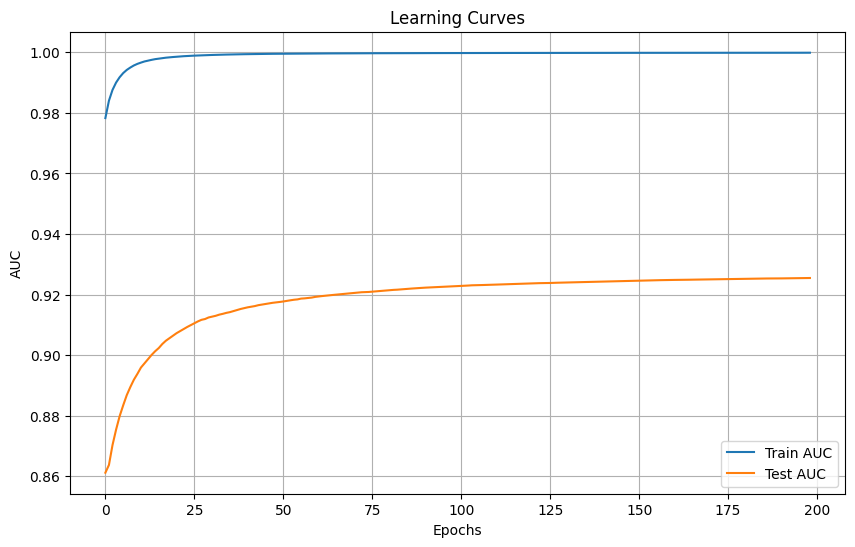

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_auc, label='Train AUC')
plt.plot(test_auc, label='Test AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data preprocessing

In [ ]:
#read in data
higgs_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/higgs.csv")
higgs_df.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label,KaggleSet,KaggleWeight
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s,t,0.002653
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b,t,2.233584
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b,t,2.347389
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b,t,5.446378
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b,t,6.245333


In [ ]:
# drop irrelevant columns (ID, kaggleset, kaggleweight)
higgs_df.drop(["EventId", "KaggleSet", "KaggleWeight"], axis=1, inplace=True)

In [ ]:
# dataset of just the features for measuring correlation coefficient
# label and weight will be used in training but aren't needed to measure correlation between
# features
features = higgs_df.copy()
features.drop(["Label", "Weight"], axis=1, inplace=True)
features.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_sum_pt,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


Application of Machine Learning Algorithms for Searching BSM Higgs Bosons Decaying to a Pair of Bottom Quarks measured pearson's correlation coefficient between high-level and low-level features and discarded the high-level features with over 0.9 correlation (high correlation). This is because the high-level features do not provide additional meaning to the model (ie. the presence of their highly-correlated low-level variable makes them redundant), but still cost resources and add to the models complexity.

https://medium.com/@sujathamudadla1213/why-we-have-to-remove-highly-correlated-features-in-machine-learning-9a8416286f18

In [ ]:
# get only features as df
features = higgs_df.drop(["Weight", "Label"], axis=1)

#split features into high and low level
#der = derived, pri =  primitive
der_cols = []
pri_cols =  []
for col in features.columns:
    if "DER" in col:
        der_cols.append(col)
    else:
        pri_cols.append(col)
print("Low level feature columns:", pri_cols)
print()
print("High level feature columns:", der_cols)


Low level feature columns: ['PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']

High level feature columns: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality']


In [ ]:
low_level = features[pri_cols]
high_level = features[der_cols]

low_level.head()

,PRI_tau_pt,PRI_tau_eta,PRI_tau_phi,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_met,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,32.638,1.017,0.381,51.626,2.273,-2.414,16.824,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,42.014,2.039,-3.011,36.918,0.501,0.103,44.704,-1.916,164.546,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,32.154,-0.705,-2.093,121.409,-0.953,1.052,54.283,-2.186,260.414,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,22.647,-1.655,0.010,53.321,-0.522,-3.100,31.082,0.060,86.062,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000
4,28.209,-2.197,-2.231,29.774,0.798,1.569,2.723,-0.871,53.131,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


In [ ]:
# to store the high-level variables with high correlation to low_level variables
# set to remove duplicates
hcol_set = set()

#measure correlation coefficient between high-level and low-level variables
for hcol in der_cols:
    for lcol in pri_cols:
        corr = high_level[hcol].corr(low_level[lcol])
        if corr > 0.9:
            print(hcol, "correlation with", lcol, "is", corr)
            hcol_set.add(hcol)
print()
print(hcol_set)

DER_deltaeta_jet_jet correlation with PRI_jet_subleading_pt is 0.9993266175807585
DER_deltaeta_jet_jet correlation with PRI_jet_subleading_eta is 0.9999949365194293
DER_deltaeta_jet_jet correlation with PRI_jet_subleading_phi is 0.9999955404703277
DER_mass_jet_jet correlation with PRI_jet_subleading_pt is 0.9475357592387109
DER_mass_jet_jet correlation with PRI_jet_subleading_eta is 0.9453523348129185
DER_mass_jet_jet correlation with PRI_jet_subleading_phi is 0.9453555500422137
DER_prodeta_jet_jet correlation with PRI_jet_subleading_pt is 0.9993274101123129
DER_prodeta_jet_jet correlation with PRI_jet_subleading_eta is 0.9999880011866814
DER_prodeta_jet_jet correlation with PRI_jet_subleading_phi is 0.9999885887198753
DER_sum_pt correlation with PRI_met_sumet is 0.9051252423696503
DER_sum_pt correlation with PRI_jet_all_pt is 0.9656906142722486
DER_lep_eta_centrality correlation with PRI_jet_subleading_pt is 0.9993351248504362
DER_lep_eta_centrality correlation with PRI_jet_subleading

In [ ]:
# discard those highly correlated variables
for col in hcol_set:
    higgs_df.drop([col], axis=1, inplace=True)
higgs_df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,138.470,51.655,97.827,27.980,3.064,41.928,1.582,1.396,32.638,1.017,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.000814,s
1,160.937,68.768,103.235,48.146,3.473,2.078,0.879,1.414,42.014,2.039,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,0.681042,b
2,-999.000,162.172,125.953,35.635,3.148,9.336,3.776,1.414,32.154,-0.705,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,0.715742,b
3,143.905,81.417,80.943,0.414,3.310,0.414,2.354,-1.285,22.647,-1.655,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,1.660654,b
4,175.864,16.915,134.805,16.405,3.891,16.405,1.056,-1.385,28.209,-2.197,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,1.904263,b


With our reduced set of features, we will now search for any missing values. Apparently, a common approach when cleaning and preprocessing this dataset for the Kaggle challenge was to replace missing values with their mean. However, as this dataset is quite large for my machine to process already, if the missing values comprise a negligable amount of the data then I will remove those entries entirely.

In [ ]:
higgs_df.isna().any()

DER_mass_MMC                   False
DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
PRI_met_sumet                  False
PRI_jet_num                    False
PRI_jet_leading_pt             False
PRI_jet_leading_eta            False
PRI_jet_leading_phi            False
PRI_jet_subleading_pt          False
PRI_jet_subleading_eta         False
PRI_jet_subleading_phi         False
PRI_jet_all_pt                 False
Weight                         False
Label                          False
d

There doesn't appear to be any missing values at first glance, but they could have been using a numerical stand-in to represent the missing values, which requires deeper investigation.

After investigating, I found in previous attempts to use this data, it was discovered that "-999" is used to represent missing data. https://www.kaggle.com/competitions/higgs-boson/discussion/9397

In [ ]:
# replace all -999 with nan to show missing data
higgs_df.replace(-999, np.nan, inplace=True)
higgs_df.isna().any()


DER_mass_MMC                    True
DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
PRI_met_sumet                  False
PRI_jet_num                    False
PRI_jet_leading_pt              True
PRI_jet_leading_eta             True
PRI_jet_leading_phi             True
PRI_jet_subleading_pt           True
PRI_jet_subleading_eta          True
PRI_jet_subleading_phi          True
PRI_jet_all_pt                 False
Weight                         False
Label                          False
d

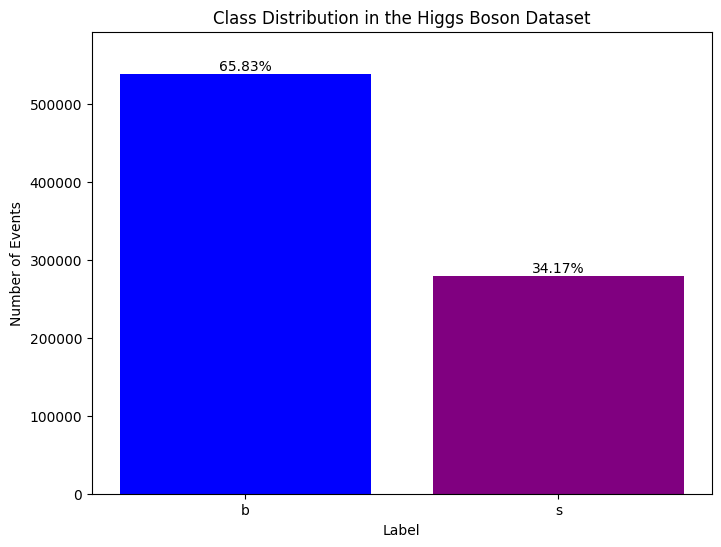

In [ ]:
# Calculate the count and percentage of each label category
label_counts = higgs_df['Label'].value_counts()
total_samples = len(higgs_df)
label_percentages = label_counts / total_samples * 100

# Plotting the bar chart
plt.figure(figsize=(8, 6))
bars = plt.bar(label_counts.index, label_counts, color=['blue', 'purple'])

# Adding percentages above each bar
for bar, percentage in zip(bars, label_percentages):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 50, f'{percentage:.2f}%', ha='center', va='bottom')

# Adding labels and titles
plt.title('Class Distribution in the Higgs Boson Dataset')
plt.xlabel('Label')
plt.ylabel('Number of Events')
plt.ylim(0, max(label_counts) * 1.1)  # Adjust ylim to leave space for percentages
plt.show()


In [ ]:
print("Missing values:", higgs_df["DER_mass_MMC"].isna().sum())
print("Out of:", len(higgs_df["DER_mass_MMC"]))

Missing values: 124602
Out of: 818238


In [ ]:
missing_and_signal = higgs_df[(higgs_df['Label'] == 's') & higgs_df.isnull().any(axis=1)].shape[0]
signal = higgs_df[(higgs_df['Label'] == 's')].shape[0]
missing = higgs_df["DER_mass_MMC"].isna().sum()
all = len(higgs_df)
missing_and_background = higgs_df[(higgs_df['Label'] == 'b') & higgs_df.isnull().any(axis=1)].shape[0]
background = higgs_df[(higgs_df['Label'] == 'b')].shape[0]

In [ ]:
print("signal", signal)
print("background", background)

signal 279560
background 538678


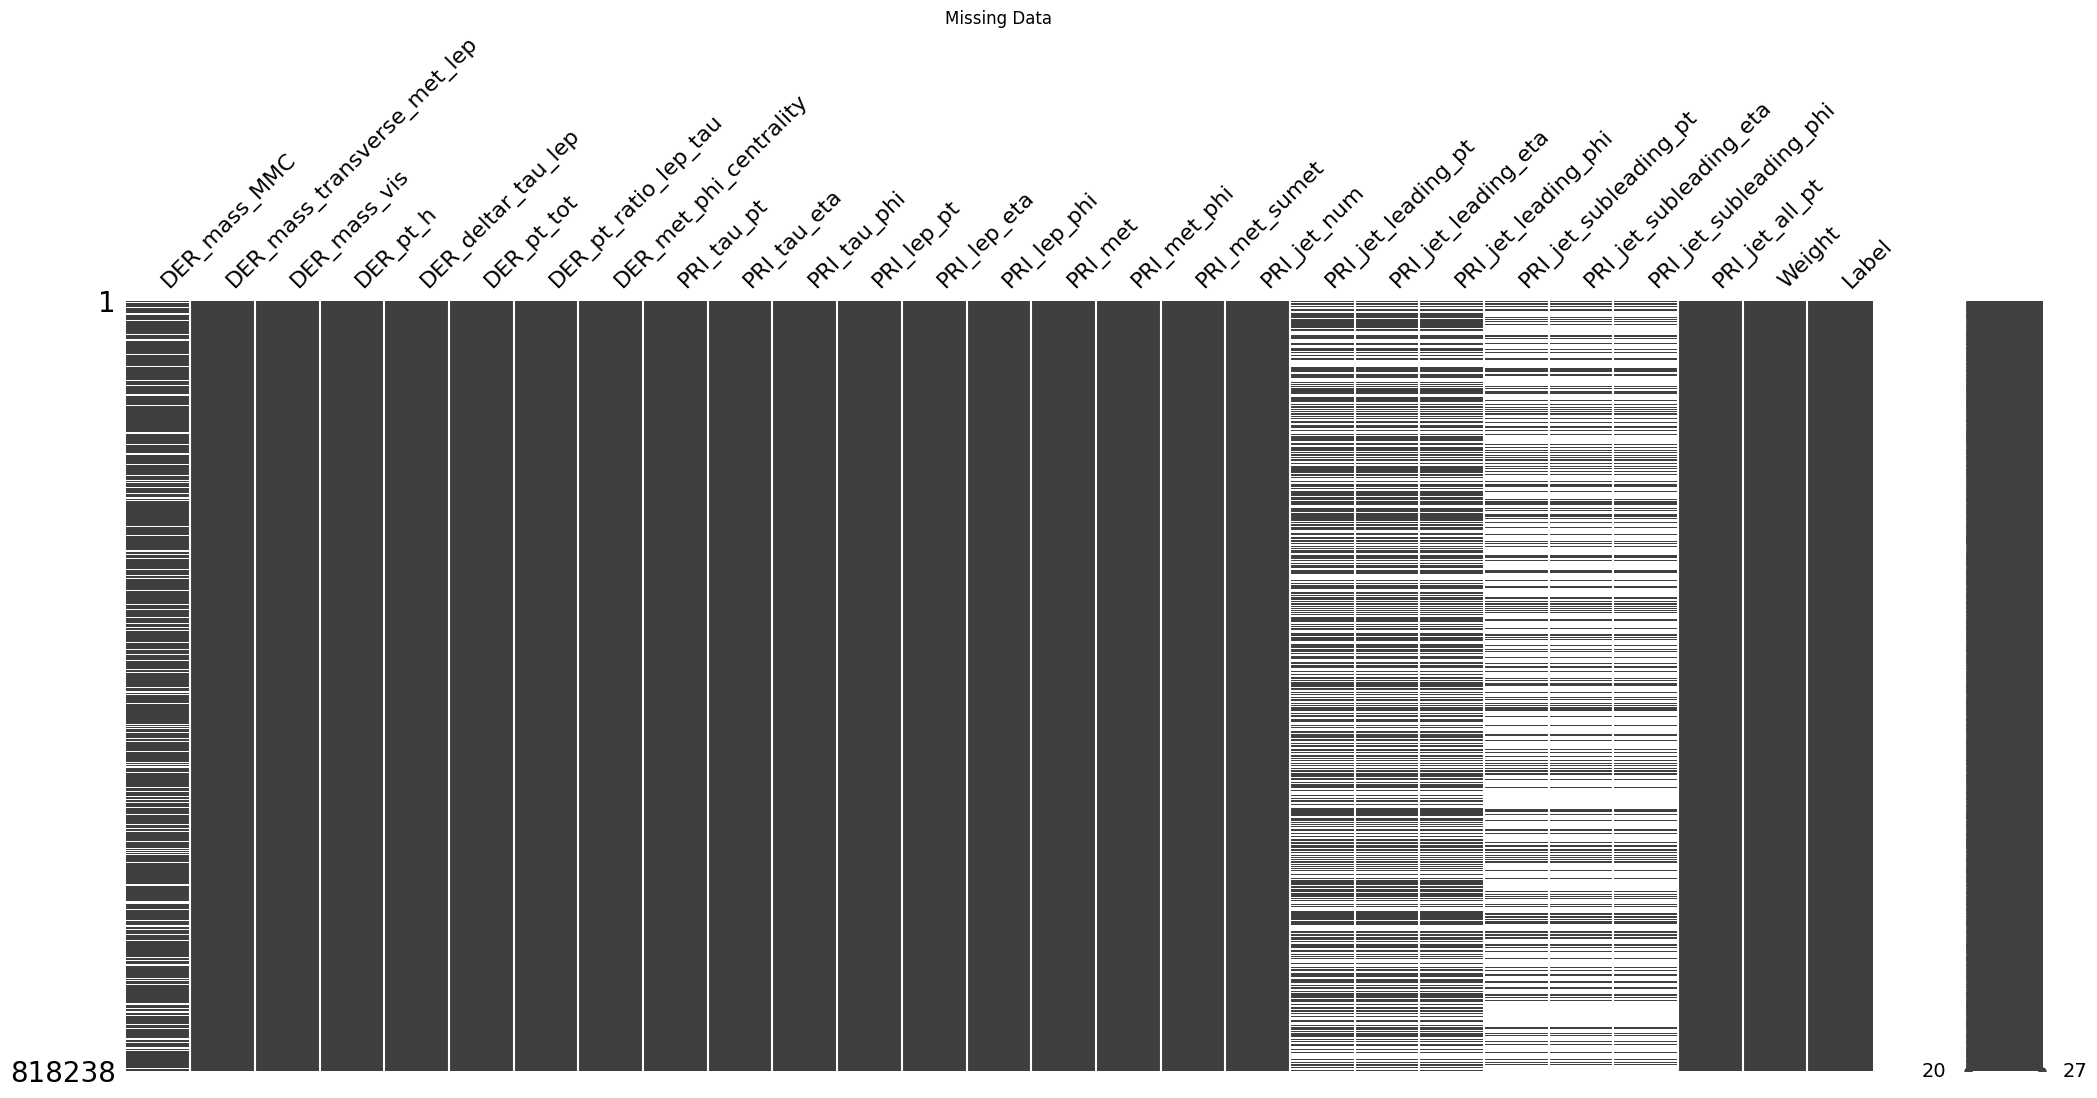

In [ ]:
import missingno as msno

msno.matrix(higgs_df)
plt.title("Missing Data")
plt.show()


In [ ]:
missing_signal_percent = (missing_and_signal / signal) * 100
missing_percent =(missing_and_background / background) * 100

In [ ]:
print(missing_signal_percent, "percent of signal events are missing mass.")
print(missing_percent, "percent of bg events are missing mass.")

62.5701101731292 percent of signal events are missing mass.
77.9209472077939 percent of bg events are missing mass.


In [ ]:
# Making a copy of the df without the label or weights (features only)
features = higgs_df.iloc[:, 0:-2]
# df_sub = higgs_df["DER_Mass_MMC"]
features.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470,51.655,97.827,27.980,3.064,41.928,1.582,1.396,32.638,1.017,...,-0.277,258.733,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,3.473,2.078,0.879,1.414,42.014,2.039,...,-1.916,164.546,1,46.226,0.725,1.158,NaN,NaN,NaN,46.226
2,NaN,162.172,125.953,35.635,3.148,9.336,3.776,1.414,32.154,-0.705,...,-2.186,260.414,1,44.251,2.053,-2.028,NaN,NaN,NaN,44.251
3,143.905,81.417,80.943,0.414,3.310,0.414,2.354,-1.285,22.647,-1.655,...,0.060,86.062,0,NaN,NaN,NaN,NaN,NaN,NaN,-0.000
4,175.864,16.915,134.805,16.405,3.891,16.405,1.056,-1.385,28.209,-2.197,...,-0.871,53.131,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000


<Axes: >

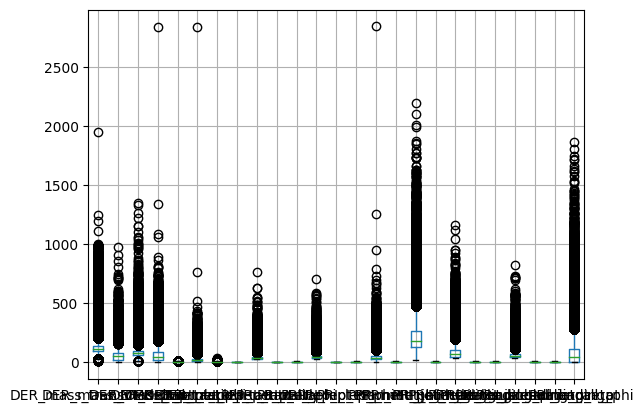

In [ ]:
features.boxplot()

In [ ]:
# create boolean mask to show where the missing values are
# this will be used later to replace them with 0 for xgboost and impute them properly once the outliers are gone
nan_mask = higgs_df.isna()
nan_mask.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,True,True,True,True,True,True,False,False,False


In [ ]:
# Impute missing values using SimpleImputer (replace NaNs with column means)
imputer = SimpleImputer(strategy='mean')
df_imputed = pd.DataFrame(imputer.fit_transform(features), columns=features.columns)

df_imputed.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,...,PRI_met_phi,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt
0,138.470000,51.655,97.827,27.980,3.064,41.928,1.582,1.396,32.638,1.017,...,-0.277,258.733,2.0,67.435000,2.150000,0.444000,46.062000,1.240000,-2.47500,113.497
1,160.937000,68.768,103.235,48.146,3.473,2.078,0.879,1.414,42.014,2.039,...,-1.916,164.546,1.0,46.226000,0.725000,1.158000,57.810286,-0.006669,-0.01047,46.226
2,121.867697,162.172,125.953,35.635,3.148,9.336,3.776,1.414,32.154,-0.705,...,-2.186,260.414,1.0,44.251000,2.053000,-2.028000,57.810286,-0.006669,-0.01047,44.251
3,143.905000,81.417,80.943,0.414,3.310,0.414,2.354,-1.285,22.647,-1.655,...,0.060,86.062,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,-0.000
4,175.864000,16.915,134.805,16.405,3.891,16.405,1.056,-1.385,28.209,-2.197,...,-0.871,53.131,0.0,84.904285,-0.001248,-0.018856,57.810286,-0.006669,-0.01047,0.000


In [ ]:
print(df_imputed.columns)

Index(['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis',
       'DER_pt_h', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_pt_ratio_lep_tau',
       'DER_met_phi_centrality', 'PRI_tau_pt', 'PRI_tau_eta', 'PRI_tau_phi',
       'PRI_lep_pt', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met', 'PRI_met_phi',
       'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_leading_pt',
       'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_pt',
       'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt'],
      dtype='object')


In [ ]:
threshold_z = 5
z = np.abs(stats.zscore(df_imputed))

# add the labels and weights back on

df_imputed["Weight"] = higgs_df["Weight"]
df_imputed["Label"] = higgs_df["Label"]

outlier_indices = np.where(z > threshold_z)[0]
no_outliers = df_imputed.drop(outlier_indices)
print("Original DataFrame Shape:", df_imputed.shape)
print("DataFrame Shape after Removing Outliers:", no_outliers.shape)


Original DataFrame Shape: (818238, 27)
DataFrame Shape after Removing Outliers: (792483, 27)


In [ ]:
# also remove the outliers from the nan_mask so we can use that later too

nan_mask = nan_mask.drop(outlier_indices)
len(nan_mask)

792483

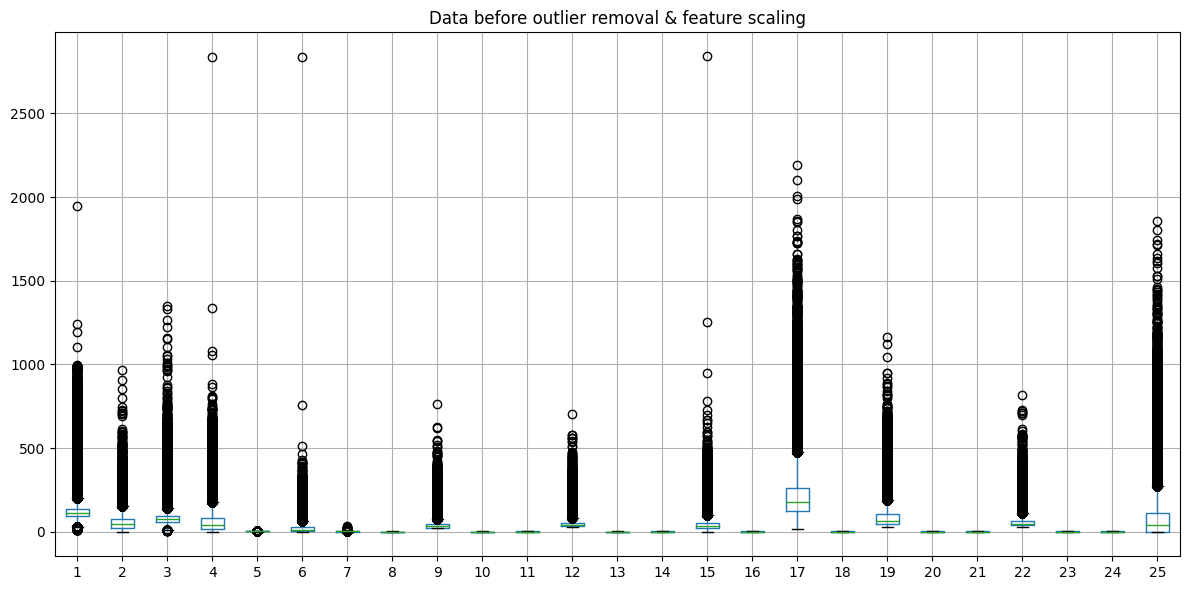

In [ ]:
# Create a boxplot with feature names replaced by numbers
plt.figure(figsize=(12, 6))
features.boxplot()
plt.xticks(range(1, len(features.columns) + 1), range(1, len(features.columns) + 1))
plt.title("Data before outlier removal & feature scaling")
plt.tight_layout()
plt.show()


Now I have a dataframe of imputed & cleaned data, I will log scale the positive features, and simplescaler all the features.(CITE WHY FOR XGBOOST) Then, I will place the missing values back in so I can create the two datasets that I will be using for my models: zeroes_df and imputed_df.

First up, log transformation:

In [ ]:
# Find the columns which contain 0 or negative values
negative_features = features.columns[(features <= 0).any()].tolist()
print(negative_features)

['DER_mass_transverse_met_lep', 'DER_pt_h', 'DER_pt_tot', 'DER_met_phi_centrality', 'PRI_tau_eta', 'PRI_tau_phi', 'PRI_lep_eta', 'PRI_lep_phi', 'PRI_met_phi', 'PRI_jet_num', 'PRI_jet_leading_eta', 'PRI_jet_leading_phi', 'PRI_jet_subleading_eta', 'PRI_jet_subleading_phi', 'PRI_jet_all_pt']


In [ ]:
# drop these columns for a subset containing only positive values
positive_features = features.drop(negative_features, axis=1)
positive_features.head()

,DER_mass_MMC,DER_mass_vis,DER_deltar_tau_lep,DER_pt_ratio_lep_tau,PRI_tau_pt,PRI_lep_pt,PRI_met,PRI_met_sumet,PRI_jet_leading_pt,PRI_jet_subleading_pt
0,138.470,97.827,3.064,1.582,32.638,51.626,16.824,258.733,67.435,46.062
1,160.937,103.235,3.473,0.879,42.014,36.918,44.704,164.546,46.226,NaN
2,NaN,125.953,3.148,3.776,32.154,121.409,54.283,260.414,44.251,NaN
3,143.905,80.943,3.310,2.354,22.647,53.321,31.082,86.062,NaN,NaN
4,175.864,134.805,3.891,1.056,28.209,29.774,2.723,53.131,NaN,NaN


In [ ]:
# double checking there are no negative or 0 values in this positive subset
(positive_features.values <= 0).any()

False

In [ ]:
# Get the list of positive features to log transform
posi_cols = positive_features.columns.tolist()
print(posi_cols)

['DER_mass_MMC', 'DER_mass_vis', 'DER_deltar_tau_lep', 'DER_pt_ratio_lep_tau', 'PRI_tau_pt', 'PRI_lep_pt', 'PRI_met', 'PRI_met_sumet', 'PRI_jet_leading_pt', 'PRI_jet_subleading_pt']


In [ ]:
# do the log transformation on the positive features to try and help with the skew
no_outliers_log = no_outliers.copy()

for col in posi_cols:
  no_outliers_log[col] = np.log10(no_outliers[col])

no_outliers_log.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,2.141356,51.655,1.990459,27.980,0.486289,41.928,0.199206,1.396,1.513724,1.017,...,2.0,1.828885,2.150000,0.444000,1.663343,1.240000,-2.47500,113.497,0.000814,s
1,2.206656,68.768,2.013827,48.146,0.540705,2.078,-0.056011,1.414,1.623394,2.039,...,1.0,1.664886,0.725000,1.158000,1.762005,-0.006669,-0.01047,46.226,0.681042,b
2,2.085889,162.172,2.100209,35.635,0.498035,9.336,0.577032,1.414,1.507235,-0.705,...,1.0,1.645923,2.053000,-2.028000,1.762005,-0.006669,-0.01047,44.251,0.715742,b
3,2.158076,81.417,1.908179,0.414,0.519828,0.414,0.371806,-1.285,1.355011,-1.655,...,0.0,1.928930,-0.001248,-0.018856,1.762005,-0.006669,-0.01047,-0.000,1.660654,b
4,2.245177,16.915,2.129706,16.405,0.590061,16.405,0.023664,-1.385,1.450388,-2.197,...,0.0,1.928930,-0.001248,-0.018856,1.762005,-0.006669,-0.01047,0.000,1.904263,b


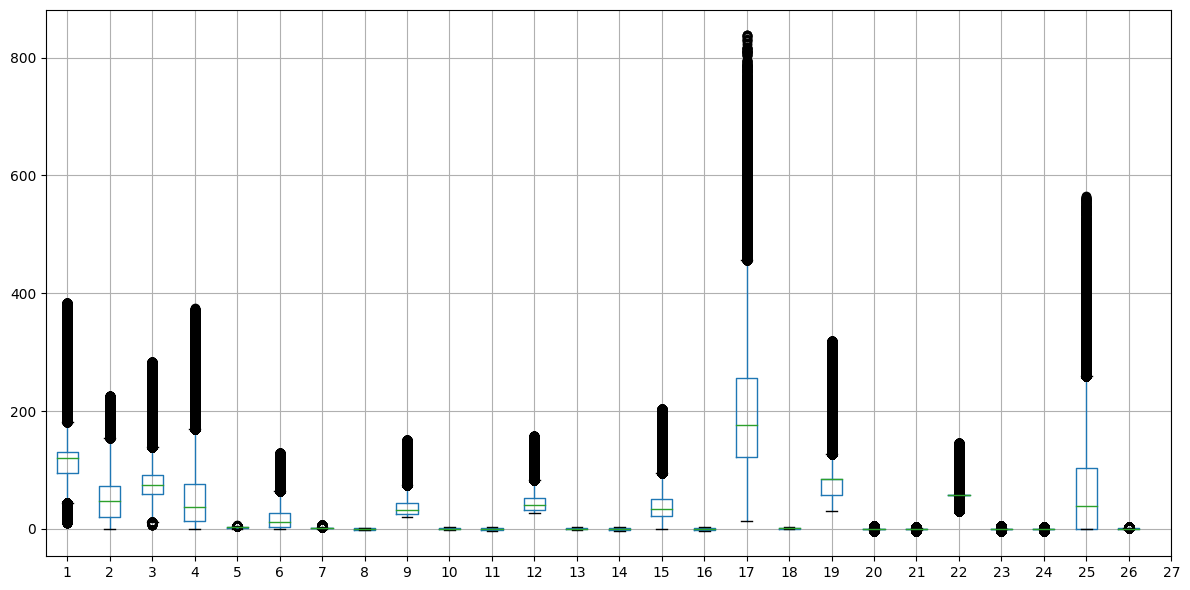

In [ ]:
# Create a boxplot with feature names replaced by numbers
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
no_outliers.boxplot()

# Replace x-axis tick labels with numbers
plt.xticks(range(1, len(no_outliers.columns) + 1), range(1, len(no_outliers.columns) + 1))

plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()


In [ ]:
no_outliers_log.isna().any()

DER_mass_MMC                   False
DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
PRI_met_sumet                  False
PRI_jet_num                    False
PRI_jet_leading_pt             False
PRI_jet_leading_eta            False
PRI_jet_leading_phi            False
PRI_jet_subleading_pt          False
PRI_jet_subleading_eta         False
PRI_jet_subleading_phi         False
PRI_jet_all_pt                 False
Weight                         False
Label                          False
d

In [ ]:
# scale all the features because they all have very different ranges

# store the weights and labels in their own variables for later
weights = no_outliers_log["Weight"]
labels = no_outliers_log["Label"]

# drop the weights and labels from no_outliers_log dataframe
no_outliers_log = no_outliers_log.drop(["Label", "Weight"], axis=1)

# carry out the scaling on the features and turn the scaled features back into a dataframe
scaler = StandardScaler()
scaled_imputed_df = pd.DataFrame(scaler.fit_transform(no_outliers_log), columns = no_outliers_log.columns)

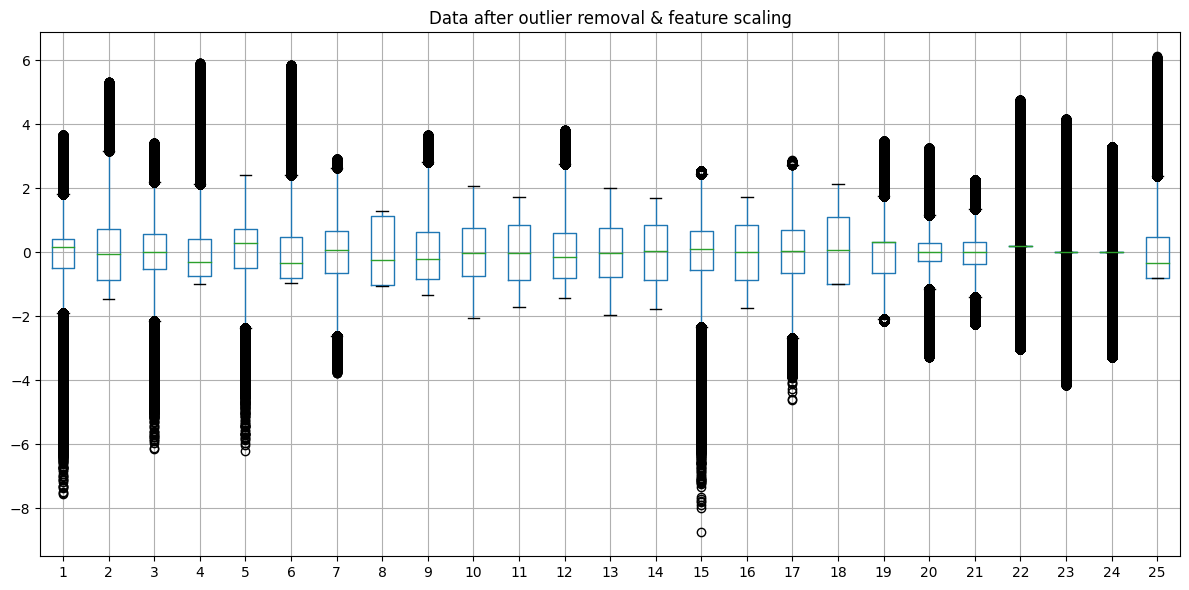

In [ ]:
# Create a boxplot with feature names replaced by numbers
plt.figure(figsize=(12, 6))
scaled_imputed_df.boxplot()
plt.xticks(range(1, len(scaled_imputed_df.columns) + 1), range(1, len(scaled_imputed_df.columns) + 1))
plt.title("Data after outlier removal & feature scaling")
plt.tight_layout()
plt.show()


In [ ]:
print(len(scaled_imputed_df))
print(len(weights))

792483
792483


In [ ]:
# append the label and weights columns back on to the features ?
# this will create the dataset of imputed features, outliers removed, log transformed & scaled
weights.index = scaled_imputed_df.index
labels.index = scaled_imputed_df.index

scaled_imputed_df["Weight"] = weights
scaled_imputed_df["Label"] = labels

scaled_imputed_df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,0.613141,0.087356,0.727810,-0.470930,0.820883,1.265071,0.465712,1.289025,-0.118339,0.849142,...,1.097077,-0.229914,1.560829,0.332384,-0.918763,1.152111,-2.579100,0.590569,0.000814,s
1,1.063668,0.600766,0.863095,-0.098524,1.148461,-0.840825,-0.662333,1.304087,0.504867,1.692583,...,0.056454,-1.131144,0.526990,0.844723,0.203395,-0.000492,-0.000226,-0.235681,0.681042,b
2,0.230455,3.402998,1.363183,-0.329565,0.891592,-0.457272,2.135674,1.304087,-0.155210,-0.571997,...,0.056454,-1.235353,1.490455,-1.441430,0.203395,-0.000492,-0.000226,-0.259938,0.715742,b
3,0.728499,0.980251,0.251471,-0.979993,1.022785,-0.928760,1.228592,-0.954396,-1.020230,-1.356017,...,-0.984170,0.319863,0.000097,0.000256,0.203395,-0.000492,-0.000226,-0.803447,1.660654,b
4,1.329438,-0.954886,1.533952,-0.684687,1.445581,-0.083706,-0.310174,-1.038075,-0.478247,-1.803321,...,-0.984170,0.319863,0.000097,0.000256,0.203395,-0.000492,-0.000226,-0.803447,1.904263,b


In [ ]:
scaled_imputed_df.isna().any()

DER_mass_MMC                   False
DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
PRI_met_sumet                  False
PRI_jet_num                    False
PRI_jet_leading_pt             False
PRI_jet_leading_eta            False
PRI_jet_leading_phi            False
PRI_jet_subleading_pt          False
PRI_jet_subleading_eta         False
PRI_jet_subleading_phi         False
PRI_jet_all_pt                 False
Weight                         False
Label                          False
d

In [ ]:
# check how many signal events we lost in preprocessing to make sure we don't need to dial it back a bit with outlier removal
b4_process_s = (higgs_df["Label"]=="s").sum()
b4_process_b = (higgs_df["Label"]=="b").sum()

print("Before processing:")
print("Signal events:", b4_process_s)
print("Background events:", b4_process_b)

post_s = (scaled_imputed_df["Label"]=="s").sum()
post_b = (scaled_imputed_df["Label"]=="b").sum()

print()
print("After processing:")
print("Signal events:", post_s)
print("Background events:", post_b)

Before processing:
Signal events: 279560
Background events: 538678

After processing:
Signal events: 271203
Background events: 521280


In [ ]:
# Now to use the nan_mask to replace all missing values with something else for xgboost classifier
# this will create the dataset where missing=mean outliers removed, log transformed & scaled
nan_mask[['Label', 'Weight']] = nan_mask[['Label', 'Weight']].fillna(False)
nan_test = scaled_imputed_df.copy()

scaled_missing_df = nan_test.mask(nan_mask)
scaled_missing_df.head()

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltar_tau_lep,DER_pt_tot,DER_pt_ratio_lep_tau,DER_met_phi_centrality,PRI_tau_pt,PRI_tau_eta,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,0.613141,0.087356,0.727810,-0.470930,0.820883,1.265071,0.465712,1.289025,-0.118339,0.849142,...,1.097077,-0.229914,1.560829,0.332384,-0.918763,1.152111,-2.5791,0.590569,0.000814,s
1,1.063668,0.600766,0.863095,-0.098524,1.148461,-0.840825,-0.662333,1.304087,0.504867,1.692583,...,0.056454,-1.131144,0.526990,0.844723,NaN,NaN,NaN,-0.235681,0.681042,b
2,NaN,3.402998,1.363183,-0.329565,0.891592,-0.457272,2.135674,1.304087,-0.155210,-0.571997,...,0.056454,-1.235353,1.490455,-1.441430,NaN,NaN,NaN,-0.259938,0.715742,b
3,0.728499,0.980251,0.251471,-0.979993,1.022785,-0.928760,1.228592,-0.954396,-1.020230,-1.356017,...,-0.984170,NaN,NaN,NaN,NaN,NaN,NaN,-0.803447,1.660654,b
4,1.329438,-0.954886,1.533952,-0.684687,1.445581,-0.083706,-0.310174,-1.038075,-0.478247,-1.803321,...,-0.984170,NaN,NaN,NaN,NaN,NaN,NaN,-0.803447,1.904263,b


In [ ]:
scaled_missing_df = scaled_missing_df.dropna(subset=['Label'])
scaled_missing_df.isna().any()

DER_mass_MMC                    True
DER_mass_transverse_met_lep    False
DER_mass_vis                   False
DER_pt_h                       False
DER_deltar_tau_lep             False
DER_pt_tot                     False
DER_pt_ratio_lep_tau           False
DER_met_phi_centrality         False
PRI_tau_pt                     False
PRI_tau_eta                    False
PRI_tau_phi                    False
PRI_lep_pt                     False
PRI_lep_eta                    False
PRI_lep_phi                    False
PRI_met                        False
PRI_met_phi                    False
PRI_met_sumet                  False
PRI_jet_num                    False
PRI_jet_leading_pt              True
PRI_jet_leading_eta             True
PRI_jet_leading_phi             True
PRI_jet_subleading_pt           True
PRI_jet_subleading_eta          True
PRI_jet_subleading_phi          True
PRI_jet_all_pt                 False
Weight                         False
Label                          False
d

In [ ]:
# Convert labels from 's' and 'b' to 1 and 0
scaled_imputed_df['Label'] = scaled_imputed_df['Label'].map({'s': 1, 'b': 0})

# Alternatively, you can use the replace method
# scaled_imputed_df['Label'].replace({'s': 1, 'b': 0}, inplace=True)

# Verify the conversion
print(scaled_imputed_df['Label'].value_counts())  # Check the distribution of labels


Label
0    521280
1    271203
Name: count, dtype: int64


In [ ]:
# Convert labels from 's' and 'b' to 1 and 0
scaled_missing_df['Label'] = scaled_missing_df['Label'].map({'s': 1, 'b': 0})

# Alternatively, you can use the replace method
# scaled_imputed_df['Label'].replace({'s': 1, 'b': 0}, inplace=True)

# Verify the conversion
print(scaled_missing_df['Label'].value_counts())  # Check the distribution of labels


Label
0    504697
1    262825
Name: count, dtype: int64


Optimising for weighted AUC to increase AMS score was proposed by http://proceedings.mlr.press/v42/diaz14.pdf due to the discriminatory power of AUC, and the class imbalance present in the dataset. i didnt end up doing this but i did include the weighted auc score out of curiousity.

## run to free up memory


In [ ]:
# delete unused dataframes to save memory
del higgs_df
del no_outliers
del no_outliers_log
del features
del df_imputed

## Defining the functions for the training and testing:

In [ ]:
# The actual AMS equation
def ams(s, b):
    return math.sqrt(2 * ((s + b + 10) * math.log(1.0 + s/(b + 10)) - s))


# Getting the AMS score for a model
def get_ams_score(W, Y, Y_pred):
    s = np.sum(W * (Y == 1) * (Y_pred == 1))
    b = np.sum(W * (Y == 0) * (Y_pred == 1))
    return ams(s, b)

# Both functions are directly sourced/ written by Ritesh Prasad (and edited by me to work a bit better)
# https://medium.com/@ritesh.prasad289/higgs-boson-machine-learning-challenge-a01ecfcd3c3a

In [ ]:
def print_best_ams(probabilities, weights_val_fold, y_val_fold):
    thresholds = np.arange(1, 99)
    ams_scores = []

    for threshold in thresholds:
        limit = np.percentile(probabilities[:, 1], threshold)
        y_thresholded = probabilities[:, 1] > limit
        score = get_ams_score(weights_val_fold, y_val_fold, y_thresholded)
        ams_scores.append(score)

    best_score = max(ams_scores)
    best_threshold = thresholds[np.argmax(ams_scores)]

    print("Best AMS score:", best_score, "at threshold of:", best_threshold)

    return best_threshold, best_score

In [ ]:
def print_best_ams(probabilities, weights_val_fold, y_val_fold):
    thresholds = np.linspace(0, 1, 100)
    ams_scores = []

    for threshold in thresholds:
        y_thresholded = probabilities[:, 1] > threshold
        score = get_ams_score(weights_val_fold, y_val_fold, y_thresholded)
        ams_scores.append(score)

    best_score = max(ams_scores)
    best_threshold = thresholds[np.argmax(ams_scores)]

    print("Best AMS score:", best_score, "at threshold of:", best_threshold)

    return best_threshold, best_score


In [ ]:
# Define custom weighted AUC scorer
def weighted_auc(y_true, y_pred, sample_weight):
    auc = roc_auc_score(y_true, y_pred, sample_weight=sample_weight)
    return auc

# Create scorer object
weighted_auc_scorer = make_scorer(weighted_auc, greater_is_better=True)


## Creating the test/ train splits

Execute this cell to use imputed data:

In [ ]:
# Extract features, labels, and weights from the DataFrame
X = scaled_imputed_df.drop(columns=['Label', 'Weight']).values
y = scaled_imputed_df['Label'].values
weights = scaled_imputed_df['Weight'].values

# Splitting the dataset into training and test sets (90% training, 10% test)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.1, random_state=42)

# Printing the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape, weights_train.shape)
print("Test set shape:", X_test.shape, y_test.shape, weights_test.shape)

Training set shape: (713234, 25) (713234,) (713234,)
Test set shape: (79249, 25) (79249,) (79249,)


In [ ]:
# Extract features, labels, and weights from the DataFrame
X = scaled_imputed_df.drop(columns=['Label', 'Weight']).values
y = scaled_imputed_df['Label'].values
weights = scaled_imputed_df['Weight'].values

# Splitting the dataset into training and combined test-dev sets (80% training, 20% test-dev)
X_train, X_test_dev, y_train, y_test_dev, weights_train, weights_test_dev = train_test_split(X, y, weights, test_size=0.2, random_state=42)

# Further splitting the test-dev set into dev and test sets (50% of test-dev for dev, 50% for test)
X_dev, X_test, y_dev, y_test, weights_dev, weights_test = train_test_split(X_test_dev, y_test_dev, weights_test_dev, test_size=0.5, random_state=42)

# Printing the shapes of the training, dev, and test sets
print("Training set shape:", X_train.shape, y_train.shape, weights_train.shape)
print("Dev set shape:", X_dev.shape, y_dev.shape, weights_dev.shape)
print("Test set shape:", X_test.shape, y_test.shape, weights_test.shape)


Training set shape: (633986, 25) (633986,) (633986,)
Dev set shape: (79248, 25) (79248,) (79248,)
Test set shape: (79249, 25) (79249,) (79249,)


Execute this cell to use data with missing values:

In [ ]:
# missing data dataset
# Extract features, labels, and weights from the DataFrame
X = scaled_missing_df.drop(columns=['Label', 'Weight']).values
y = scaled_missing_df['Label'].values
weights = scaled_missing_df['Weight'].values

# Splitting the dataset into training and test sets (90% training, 10% test)
X_train, X_test, y_train, y_test, weights_train, weights_test = train_test_split(X, y, weights, test_size=0.1, random_state=42)

# Printing the shapes of the training and test sets
print("Training set shape:", X_train.shape, y_train.shape, weights_train.shape)
print("Test set shape:", X_test.shape, y_test.shape, weights_test.shape)

Training set shape: (690769, 25) (690769,) (690769,)
Test set shape: (76753, 25) (76753,) (76753,)


In [ ]:
# Counting the number of true labels in the training set
num_true_train = sum(y_train)

# Counting the number of true labels in the test set
num_true_test = sum(y_test)

print("Number of true labels in the training set:", num_true_train)
print("Number of true labels in the test set:", num_true_test)


Number of true labels in the training set: 236601
Number of true labels in the test set: 26224


# XGBoost classifier training & testing

## gridsearch

In [ ]:
# Define XGBoost classifier
xgb_classifier = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss') #add num_jobs=-1

In [ ]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}

# Define F1-score scorer for class 1
f1_scorer = make_scorer(f1_score, pos_label=1)

# Define stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Perform GridSearchCV with stratified k-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_classifier,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=stratified_kfold
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train, sample_weight=weights_train)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)


{'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9}


In [ ]:
best_parameters_f1= {'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9}

## cross validation

In [ ]:
# Define data matrix
dtrain = xgb.DMatrix(data=X_train, label=y_train, weight=weights_train)

# Define parameter grid with custom evaluation metric
param_grid = {
    'learning_rate': 0.5,
    'max_depth': 0,
    'min_child_weight': 1,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Perform cross-validation using xgboost.cv
cv_results = xgb.cv(
    params=param_grid,
    dtrain=dtrain,
    num_boost_round=200,
    nfold=5,
    early_stopping_rounds=10,
    seed=42,
    maximize=True,
    metrics={'auc'},
    #custom_metric=get_ams_score,
    verbose_eval=True
)


## Training and testing the model on the test dataset

In [ ]:
# XGBoost model
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.5,
    max_depth=0,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.9,
    eval_metric='auc',
    early_stopping_rounds=10
)

# Train
xgb_classifier.fit(
    X_train, y_train, sample_weight=weights_train,
    eval_set=[(X_train, y_train), (X_dev, y_dev)],  # Dev set for eval avoids overfit
    verbose=True
)

# Test
probabilities = xgb_classifier.predict_proba(X_test)

# Calculate best threshold for AMS and get best AMS score

#print_best_ams(probabilities, weights_val_fold, y_val_fold)
best_threshold, best_ams = print_best_ams(probabilities, weights_test, y_test)

# Convert probabilities to binary predictions using the best threshold
predictions = (probabilities[:, 1] > best_threshold).astype(int)

# Calculate weighted AUC score for validation dataset using the best threshold
weighted_auc_score = weighted_auc(y_test, predictions, sample_weight=weights_test)
print(f"Weighted AUC Score:", weighted_auc_score)

print("Report at best AMS threshold:")
report = classification_report(y_test, predictions)
print(report)


standard_predictions = (probabilities[:, 1] > 0.5).astype(int)

# Calculate weighted AUC score for validation dataset using 0.5
weighted_auc_score = weighted_auc(y_test, standard_predictions, sample_weight=weights_test)
print(f"Weighted AUC Score:", weighted_auc_score)

print("Report at 0.5 threshold:")
report2 = classification_report(y_test, standard_predictions)
print(report2)

print("AMS score at 0.5:")
get_ams_score(weights_test, y_test, standard_predictions)



[0]	validation_0-auc:0.74720	validation_1-auc:0.75010
[1]	validation_0-auc:0.80286	validation_1-auc:0.80529
[2]	validation_0-auc:0.82294	validation_1-auc:0.82533
[3]	validation_0-auc:0.82893	validation_1-auc:0.83127
[4]	validation_0-auc:0.85370	validation_1-auc:0.85479
[5]	validation_0-auc:0.86188	validation_1-auc:0.86289
[6]	validation_0-auc:0.86514	validation_1-auc:0.86617
[7]	validation_0-auc:0.86919	validation_1-auc:0.86977
[8]	validation_0-auc:0.87349	validation_1-auc:0.87389
[9]	validation_0-auc:0.87778	validation_1-auc:0.87781
[10]	validation_0-auc:0.88105	validation_1-auc:0.88085
[11]	validation_0-auc:0.88632	validation_1-auc:0.88563
[12]	validation_0-auc:0.88781	validation_1-auc:0.88686
[13]	validation_0-auc:0.89009	validation_1-auc:0.88881
[14]	validation_0-auc:0.89210	validation_1-auc:0.89047
[15]	validation_0-auc:0.89350	validation_1-auc:0.89165
[16]	validation_0-auc:0.89466	validation_1-auc:0.89269
[17]	validation_0-auc:0.89594	validation_1-auc:0.89371
[18]	validation_0-au

0.7063310927379481

Best AMS score: 1.049740138299396 at threshold of: 0.08080808080808081


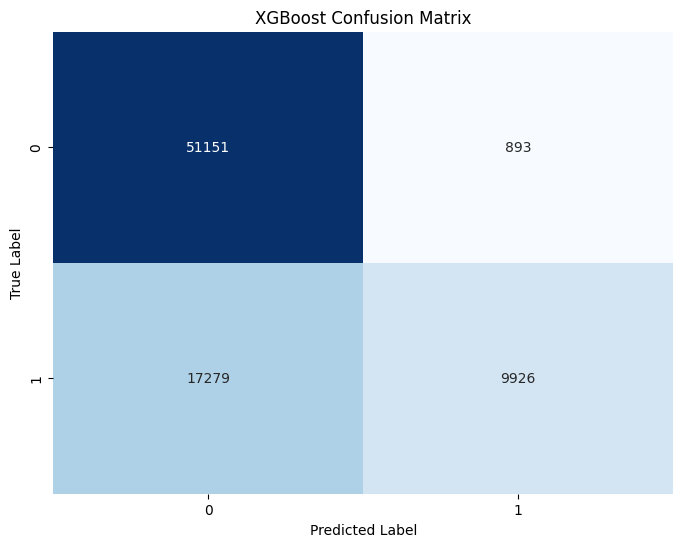

In [ ]:
# Test
probabilities = xgb_classifier.predict_proba(X_test)

# Calculate best threshold for AMS and get best AMS score
#print_best_ams(probabilities, weights_val_fold, y_val_fold)
best_threshold, best_ams = print_best_ams(probabilities, weights_test, y_test)

# Convert probabilities to binary predictions using the best threshold
predictions = (probabilities[:, 1] > best_threshold).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Ada training & testing

## gridsearch cv

In [ ]:
dt = DecisionTreeClassifier()

# Define AdaBoost classifier
adaboost_classifier = AdaBoostClassifier(estimator=dt)

In [ ]:
# Define the parameter grid for AdaBoost
param_grid_adaboost = {
    'estimator__max_depth':[10],
    #'n_estimators':[50, 100],
    'learning_rate':[0.01, 0.1, 0.5]
}

# Define F1-score scorer for class 1
f1_scorer = make_scorer(f1_score, pos_label=1)

# Define stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

# Perform GridSearchCV with stratified k-fold cross-validation for AdaBoost
grid_search_adaboost = GridSearchCV(
    estimator=adaboost_classifier,
    param_grid=param_grid_adaboost,
    scoring=f1_scorer,
    cv=stratified_kfold,
    verbose=3
)

# Fit the GridSearchCV to the training data
grid_search_adaboost.fit(X_train, y_train, sample_weight=weights_train)

# Get the best parameters
best_params_adaboost = grid_search_adaboost.best_params_
print(best_params_adaboost)


Fitting 4 folds for each of 3 candidates, totalling 12 fits
[CV 1/4] END estimator__max_depth=10, learning_rate=0.01;, score=0.081 total time=20.2min
[CV 2/4] END estimator__max_depth=10, learning_rate=0.01;, score=0.089 total time=20.0min
[CV 3/4] END estimator__max_depth=10, learning_rate=0.01;, score=0.080 total time=20.4min


## training and testing model

In [ ]:
import time
from google.colab import output


In [ ]:
# Base estimator
dt = DecisionTreeClassifier(max_depth= 10)

# AdaBoost model
ada_classifier = AdaBoostClassifier(
    estimator= dt,
    n_estimators= 100,
    learning_rate= 0.5,
    random_state=42
)

# Train
ada_classifier.fit(
    X_train, y_train, sample_weight=weights_train
)

# Test
probabilities = ada_classifier.predict_proba(X_test)

# Calculate best threshold for AMS and get best AMS score
#print_best_ams(probabilities, weights_val_fold, y_val_fold)
best_threshold, best_ams = print_best_ams(probabilities, weights_test, y_test)

# Convert probabilities to binary predictions using the best threshold
predictions = (probabilities[:, 1] > best_threshold).astype(int)

# Calculate weighted AUC score for validation dataset using the best threshold
weighted_auc_score = weighted_auc(y_test, predictions, sample_weight=weights_test)
print(f"Weighted AUC Score:", weighted_auc_score)

print("Report at best AMS threshold:")
report = classification_report(y_test, predictions)
print(report)


standard_predictions = (probabilities[:, 1] > 0.5).astype(int)

# Calculate weighted AUC score for validation dataset using 0.5
weighted_auc_score = weighted_auc(y_test, standard_predictions, sample_weight=weights_test)
print(f"Weighted AUC Score:", weighted_auc_score)

print("Report at 0.5 threshold:")
report2 = classification_report(y_test, standard_predictions)
print(report2)

print("AMS score at 0.5:")
get_ams_score(weights_test, y_test, standard_predictions)

for i in range(0,2):
  output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/9/93/Start.wav").play()')
  time.sleep(2)


Best AMS score: 0.8755745001995338 at threshold of: 0.4545454545454546
Weighted AUC Score: 0.7624221471009434
Report at best AMS threshold:
              precision    recall  f1-score   support

           0       0.82      0.92      0.87     52181
           1       0.80      0.62      0.70     27068

    accuracy                           0.82     79249
   macro avg       0.81      0.77      0.78     79249
weighted avg       0.81      0.82      0.81     79249

Weighted AUC Score: 0.525140537848178
Report at 0.5 threshold:
              precision    recall  f1-score   support

           0       0.68      0.99      0.81     52181
           1       0.83      0.12      0.21     27068

    accuracy                           0.69     79249
   macro avg       0.76      0.55      0.51     79249
weighted avg       0.73      0.69      0.60     79249

AMS score at 0.5:


In [ ]:
# Define the path to the saved model in your Google Drive
load_path = '/content/drive/My Drive/models/ada_50estims_0.45.pkl'

# Load the model
ada_classifier = joblib.load(load_path)


print("Model loaded from:", load_path)

Model loaded from: /content/drive/My Drive/models/ada_50estims_0.45.pkl


Best AMS score: 1.131047496203006 at threshold of: 0.4646464646464647


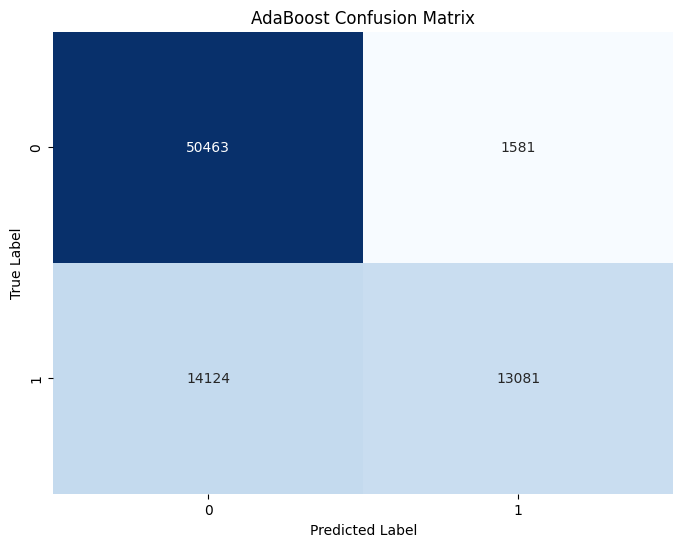

In [ ]:
# Test
probabilities = ada_classifier.predict_proba(X_test)

# Calculate best threshold for AMS and get best AMS score
#print_best_ams(probabilities, weights_val_fold, y_val_fold)
best_threshold, best_ams = print_best_ams(probabilities, weights_test, y_test)

# Convert probabilities to binary predictions using the best threshold
predictions = (probabilities[:, 1] > best_threshold).astype(int)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('AdaBoost Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Saving and loading models

In [ ]:
import joblib

# SAVE MODEL

save_path = '/content/drive/My Drive/models/xgb_imputed_08_not_overfit.pkl'

joblib.dump(xgb_classifier, save_path)

print("Model saved to:", save_path)


Model saved to: /content/drive/My Drive/models/xgb_imputed_08_not_overfit.pkl


In [ ]:
load_path = '/content/drive/My Drive/models/xgb_missing_04.pkl'

# Load the model
loaded_model = joblib.load(load_path)


print("Model loaded from:", load_path)


In [ ]:
load_path = '/content/drive/My Drive/models/xgb_imputed_08_not_overfit.pkl'

# Load the model
loaded_model = joblib.load(load_path)

print("Model loaded from:", load_path)
